##  Siyu (Fiona) Zheng     05/22/2024

### Assignment 1: Power Calendar function

__Objective:__ write R/Python function which returns number of hours by iso/peak.type/period

In power market, the industry defines certain hour of each day to peak type for block trading, so we need to calculate correctly how many hours belongs to certain block. Each ISO has a little different definition of it. Note: don't scrape data from the reference link. It's for reference only. You shall learn/understand the logic and calculate without access to any website.

- See reference: https://www.energygps.com/HomeTools/PowerCalendar

__Required Function: get.hours(iso, peak.type, period)__

Params: (all params are required in the function)
- iso (character): one of PJM/MISO/ERCOT/SPP/NYISO/WECC/CAISO (see item 1 below)
- peak.type (character): one of onpeak/offpeak/flat/2x16H/7x8
- period (character): has 4 types: “2018-2-3” as a daily, “2018Mar” as a monthly, “2018Q2” as a quarterly, “2018A” as an annually.

Return: a list variable giving iso/peak.type/start.date/end.date/num.hour where num.hour is the total number of hours of that peak type in that period.

__Hint:__
1. In US, there are 7 major ISOs (PJMISO, MISO, ERCOT, SPPISO, NYISO, WECC(soon to be integrated into SPP) and CAISO) see https://www.ferc.gov/power-sales-and-markets/rtos-and-isos
2. HE, short for Hour Ending. HE2 means 01:00 - 02:00, HE14 means 13:00 - 14:00. For each single day, we have HE1 to HE24.
3. peak.type, eastern power market considers a HE to be onpeak, if it's a non-NERC holiday weekday from HE7 to HE22, the rest are offpeak HEs. If the peak.type is flat, that means every hour. 2x16H is HE7 to HE22 for the weekend and the NERC holiday. 7x8 is non HE7 to HE22 through the week. Different ISO has different definition of peak type.
4. MISO does not have the daylight-saving setting, the rest have. (Hint: daylight-savings will impact the function for certain month/peak.type.)

In [4]:
pip install holidays

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import datetime
import holidays

In [6]:
# Function to parse period input
def parse_period(period):
    if 'Q' in period:
        year = int(period[:4])
        quarter = int(period[-1])
        start_date = pd.to_datetime(f'{year}Q{quarter}').to_period('Q').start_time.date()
        end_date = pd.to_datetime(f'{year}Q{quarter}').to_period('Q').end_time.date()
    elif period.endswith('A'):
        year = int(period[:-1])
        start_date = datetime.date(year, 1, 1)
        end_date = datetime.date(year, 12, 31)
    elif '-' in period:
        start_date = pd.to_datetime(period).date()
        end_date = start_date
    else:
        year = int(period[:4])
        month_str = period[4:]
        month = datetime.datetime.strptime(month_str, '%b').month
        start_date = datetime.date(year, month, 1)
        end_date = (start_date + pd.offsets.MonthEnd()).date()
    return start_date, end_date


# Function to get peak hours based on ISO and peak type
def get_peak_hours(iso, peak_type, date, nerc_holidays):
    if iso == 'CAISO':
        if peak_type == 'onpeak':
            if date.weekday() < 6 and date not in nerc_holidays:  # Monday to Saturday
                return list(range(7, 23))  # HE7 to HE22
        elif peak_type == 'offpeak':
            if date.weekday() == 6 or date in nerc_holidays:  # Sundays and holidays
                return list(range(0, 24))
            else:
                return list(range(0, 7)) + list(range(23, 24))  # Offpeak hours for weekdays
    elif iso == 'ERCOT':
        if peak_type == 'onpeak':
            if date.weekday() < 5 and date not in nerc_holidays:  # Weekday and not a holiday
                return list(range(7, 23))  # HE7 to HE22
        elif peak_type == 'offpeak':
            if date.weekday() >= 5 or date in nerc_holidays:
                return list(range(0, 24))  # All hours for weekends and holidays
            else:
                return list(range(0, 7)) + list(range(23, 24))  # Offpeak hours for weekdays
        elif peak_type == 'flat':
            return list(range(0, 24))  # All hours
        elif peak_type == '2x16H':
            if date.weekday() >= 5 or date in nerc_holidays:
                return list(range(7, 23))  # HE7 to HE22 for weekends and holidays
        elif peak_type == '7x8':
            if date.weekday() < 5:
                return list(range(0, 7)) + list(range(23, 24))  # Non-peak hours for weekdays
    return []


# Function to calculate total peak hours in a given period
def calculate_hours(iso, peak_type, start_date, end_date, nerc_holidays):
    current_date = start_date
    total_hours = 0
    while current_date <= end_date:
        peak_hours = get_peak_hours(iso, peak_type, current_date, nerc_holidays)
        total_hours += len(peak_hours)
        current_date += datetime.timedelta(days=1)
    return total_hours


# Function to get NERC holidays for a range of years
def get_nerc_holidays(start_year, end_year):
    nerc_holidays = []
    for year in range(start_year, end_year + 1):
        us_holidays = holidays.US(years=year)
        for holiday in [
            datetime.date(year, 1, 1),  
            us_holidays.get_named('Memorial Day'),
            datetime.date(year, 7, 4),  
            us_holidays.get_named('Labor Day'),
            us_holidays.get_named('Thanksgiving'),
            datetime.date(year, 12, 25)  
        ]:
            if isinstance(holiday, list):  
                nerc_holidays.extend(holiday)
            else:
                nerc_holidays.append(holiday)
    return nerc_holidays


nerc_holidays = get_nerc_holidays(2010, 2030)

# Main function to get hours based on ISO, peak type, and period
def get_hours(iso, peak_type, period):
    start_date, end_date = parse_period(period)
    num_hours = calculate_hours(iso, peak_type, start_date, end_date, nerc_holidays)
    return {
        'iso': iso,
        'peak_type': peak_type.upper(),
        'start_date': start_date.strftime('%Y-%m-%d'),
        'end_date': end_date.strftime('%Y-%m-%d'),
        'num_hours': num_hours
    }

In [7]:
# Sample Run
results = get_hours("ERCOT", "onpeak", "2019May")
results

{'iso': 'ERCOT',
 'peak_type': 'ONPEAK',
 'start_date': '2019-05-01',
 'end_date': '2019-05-31',
 'num_hours': 352}

### Assignment 2: Meter Data formatting


__Objective:__ merge different data sources into single dataset and evaluate the dataset for anormaly (if any)

For analysis purpose, we always have different data sources to merge and format. It’s important to understand the data and format it correctly.

__Data Files:__
USA_AL_Auburn-Opelika.AP.722284_TMY3_BASE.csv This file gives hourly electricity consumptions for a resident with unit in kw (kilowatt).
new.app4.csv Assuming this is one appliance’s electricity consumption minute by minute which is not captured in the previous file. The unit in the file is in watt.

__Requirements:__
- Create script to load both files and merge.
- Given the limitation of data period, try to find the overlap period and merge the data into hourly. (ignore the year but making sure the date/hour matched)
- After merging the source files correctly, please create one more column in the output file to give total hourly consumption of electricity. (sum all columns)
- Create plots of the data and see if there’s any abnormal in the dataset and summarize any pattern observed from the data by hourl/weekday/month
- Wirte code with clear documentation.

__Hint:__
- try to show smart/efficient way to merge and sum column
- try not to hard code by column number or name but making the script re-usable for general data formatting

In [8]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from scipy import stats

In [10]:
def load_and_preprocess(filepath_1, filepath_2):
    df1 = pd.read_csv(filepath_1)
    df2 = pd.read_csv(filepath_2)

    # Preprocess df1
    df1['Date/Time'] = df1['Date/Time'].str.strip().replace({' 24:00:00': ' 00:00:00'}, regex=True)
    df1['Date/Time'] = pd.to_datetime(df1['Date/Time'], format='%m/%d %H:%M:%S', errors='coerce')
    df1['Date/Time'] = df1['Date/Time'].apply(lambda dt: dt.replace(year=2013))

    # Preprocess df2
    df2['time'] = pd.to_datetime(df2['time'], format='%m/%d/%Y %H:%M')
    df2 = df2.drop(columns=['Unnamed: 0'])
    df2_hourly = df2.set_index('time').resample('H').sum().reset_index()

    return df1, df2_hourly


def merge_and_sum(df1, df2_hourly):
    merged_df = pd.merge(df1, df2_hourly, left_on='Date/Time', right_on='time', how='inner')
    merged_df = merged_df.drop(columns=['time'])
    merged_df['W_min'] = merged_df['W_min'] * 0.001
    merged_df = merged_df.rename(columns={'W_min': "One appliance:Electricity [kW](Hourly)"})

    merged_df = merged_df.sort_values(by='Date/Time')
    merged_df['Total_Consumption'] = merged_df.drop(columns=['Date/Time']).sum(axis=1)
    return merged_df


def add_time_features(merged_df):
    merged_df['Hour'] = merged_df['Date/Time'].dt.hour
    merged_df['DayOfWeek'] = merged_df['Date/Time'].dt.dayofweek
    merged_df['Month'] = merged_df['Date/Time'].dt.month
    return merged_df


def detect_anomalies(df):

    df_anomaly = df.copy()

    df_anomaly = df_anomaly.sort_values(by='Date/Time')
    # Scale 
    scaler = StandardScaler()
    non_datetime_cols = df_anomaly.columns.difference(['Date/Time'])
    df_anomaly[non_datetime_cols] = scaler.fit_transform(df_anomaly[non_datetime_cols])

    # Decompose the time series
    result = seasonal_decompose(df_anomaly['Total_Consumption'], model='additive', period=24)
    df_anomaly['trend'] = result.trend
    df_anomaly['seasonal'] = result.seasonal
    df_anomaly['residual'] = result.resid

    # Isolation Forest
    isolation_forest = IsolationForest(n_estimators=100, contamination=0.01)
    df_anomaly['anomaly_if'] = isolation_forest.fit_predict(df_anomaly[non_datetime_cols])

    # One-Class SVM
    svm = OneClassSVM(nu=0.01, kernel="rbf", gamma=0.1)
    df_anomaly['anomaly_svm'] = svm.fit_predict(df_anomaly[non_datetime_cols])

    # Z-score on residuals
    df_anomaly['z_score_residual'] = np.abs(stats.zscore(df_anomaly['residual'].dropna()))
    anomalies_residual = df_anomaly[df_anomaly['z_score_residual'] > 3]

    return df_anomaly, anomalies_residual


def plot_data(df):
    df = df.sort_values(by='Date/Time')
    
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date/Time'], df['Total_Consumption'])
    plt.xlabel('DateTime')
    plt.ylabel('Total Consumption (kW)')
    plt.title('Total Hourly Electricity Consumption')
    plt.show()

    # Plot by hour of the day
    hourly_consumption = df.groupby('Hour')['Total_Consumption'].mean()
    hourly_consumption.plot(kind='bar', figsize=(12, 6))
    plt.xlabel('Hour of the Day')
    plt.ylabel('Average Consumption (kW)')
    plt.title('Average Hourly Electricity Consumption')
    plt.show()

    # Plot by day of the week
    daily_consumption = df.groupby('DayOfWeek')['Total_Consumption'].mean()
    daily_consumption.plot(kind='bar', figsize=(12, 6))
    plt.xlabel('Day of the Week')
    plt.ylabel('Average Consumption (kW)')
    plt.title('Average Daily Electricity Consumption')
    plt.show()

    # Plot by month
    monthly_consumption = df.groupby('Month')['Total_Consumption'].mean()
    monthly_consumption.plot(kind='bar', figsize=(12, 6))
    plt.xlabel('Month')
    plt.ylabel('Average Consumption (kW)')
    plt.title('Average Monthly Electricity Consumption')
    plt.show()


def plot_abnormality(df_anomaly,anomalies_residual):
    
    # Plot anomalies
    plt.figure(figsize=(10, 6))
    plt.plot(df_anomaly['Date/Time'], df_anomaly['Total_Consumption'], label='Total Consumption')
    plt.scatter(df_anomaly[df_anomaly['anomaly_if'] == -1]['Date/Time'], df_anomaly[df_anomaly['anomaly_if'] == -1]['Total_Consumption'], color='red', label='Anomaly (IF)')
    plt.scatter(df_anomaly[df_anomaly['anomaly_svm'] == -1]['Date/Time'], df_anomaly[df_anomaly['anomaly_svm'] == -1]['Total_Consumption'], color='orange', label='Anomaly (SVM)')
    plt.xlabel('Date/Time')
    plt.ylabel('Total Consumption (kW)')
    plt.title('Total Hourly Electricity Consumption with Anomalies')
    plt.legend()
    plt.show()

    # Plot residual anomalies
    plt.figure(figsize=(10, 6))
    plt.plot(df_anomaly['Date/Time'], df_anomaly['residual'], label='Residual')
    plt.scatter(anomalies_residual['Date/Time'], anomalies_residual['residual'], color='red', label='Anomaly')
    plt.xlabel('Date/Time')
    plt.ylabel('Residual')
    plt.title('Residuals with Anomalies')
    plt.legend()
    plt.show()

In [12]:
file1 = "/Users/dx0zart/Downloads/Assignment 2 - USA_AL_Auburn-Opelika.AP.722284_TMY3_BASE.csv"
file2 = "/Users/dx0zart/Downloads/Assignment 2 - new.app4.csv"

df1,df2_hourly = load_and_preprocess(file1,file2)
merged_df = merge_and_sum(df1,df2_hourly)
merged_df = add_time_features(merged_df)
df_anomaly, anomalies_residual = detect_anomalies(merged_df)

In [13]:
print("merged data:")
merged_df.head(5)

merged data:


,Date/Time,Electricity:Facility [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),Cooling:Electricity [kW](Hourly),HVACFan:Fans:Electricity [kW](Hourly),Electricity:HVAC [kW](Hourly),Fans:Electricity [kW](Hourly),General:InteriorLights:Electricity [kW](Hourly),General:ExteriorLights:Electricity [kW](Hourly),Appl:InteriorEquipment:Electricity [kW](Hourly),Misc:InteriorEquipment:Electricity [kW](Hourly),Water Heater:WaterSystems:Electricity [kW](Hourly),One appliance:Electricity [kW](Hourly),Total_Consumption,Hour,DayOfWeek,Month
0,2013-06-07 11:00:00,1.479426,0.018757,0.0,0.0,0.347519,0.100007,0.447526,0.100007,0.047163,0.010160,0.360615,0.272322,0.324996,57.388943,60.897441,11,4,6
1,2013-06-07 12:00:00,1.559733,0.018441,0.0,0.0,0.454263,0.130764,0.585027,0.130764,0.047163,0.010160,0.350008,0.267735,0.282996,27.227961,31.065016,12,4,6
2,2013-06-07 13:00:00,1.702835,0.019079,0.0,0.0,0.603876,0.169912,0.773789,0.169912,0.047163,0.010160,0.319024,0.276993,0.259063,111.476298,115.828105,13,4,6
3,2013-06-07 14:00:00,1.859094,0.020153,0.0,0.0,0.752179,0.211629,0.963808,0.211629,0.047163,0.010160,0.294229,0.292590,0.234500,109.021960,113.919095,14,4,6
4,2013-06-07 15:00:00,2.100629,0.021274,0.0,0.0,0.921579,0.253177,1.174756,0.253177,0.050307,0.010837,0.301026,0.308854,0.238204,5.773963,11.407785,15,4,6


In [14]:
print("Anomalies detected:")
anomalies_residual.head(5)

Anomalies detected:


,Date/Time,Electricity:Facility [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),Cooling:Electricity [kW](Hourly),HVACFan:Fans:Electricity [kW](Hourly),Electricity:HVAC [kW](Hourly),Fans:Electricity [kW](Hourly),General:InteriorLights:Electricity [kW](Hourly),...,Total_Consumption,Hour,DayOfWeek,Month,trend,seasonal,residual,anomaly_if,anomaly_svm,z_score_residual
23,2013-06-08 11:00:00,-0.122542,-0.892723,0.0,0.0,-0.192118,-0.218596,-0.198080,-0.218596,-0.709849,...,5.094089,-0.076445,0.987333,-1.382646,0.347269,1.608435,3.138385,1,1,4.259926
25,2013-06-08 13:00:00,0.351876,-0.836731,0.0,0.0,0.818776,0.672546,0.786857,0.672546,-0.709849,...,4.400434,0.212542,0.987333,-1.382646,0.347375,0.609858,3.443201,1,1,4.673591
47,2013-06-09 11:00:00,0.491474,-0.892723,0.0,0.0,0.808359,0.614556,0.765908,0.614556,-0.709849,...,5.356811,-0.076445,1.482307,-1.382646,0.262561,1.608435,3.485816,1,1,4.731424
71,2013-06-10 11:00:00,-0.197499,-0.892723,0.0,0.0,-0.493115,-0.536712,-0.503026,-0.536712,-0.709849,...,5.558777,-0.076445,-1.487536,-1.382646,0.497032,1.608435,3.453311,-1,-1,4.687311
72,2013-06-10 12:00:00,-0.148745,-0.947715,0.0,0.0,-0.262932,-0.303344,-0.272015,-0.303344,-0.709849,...,5.334151,0.068049,-1.487536,-1.382646,0.497301,2.258548,2.578302,1,1,3.499841


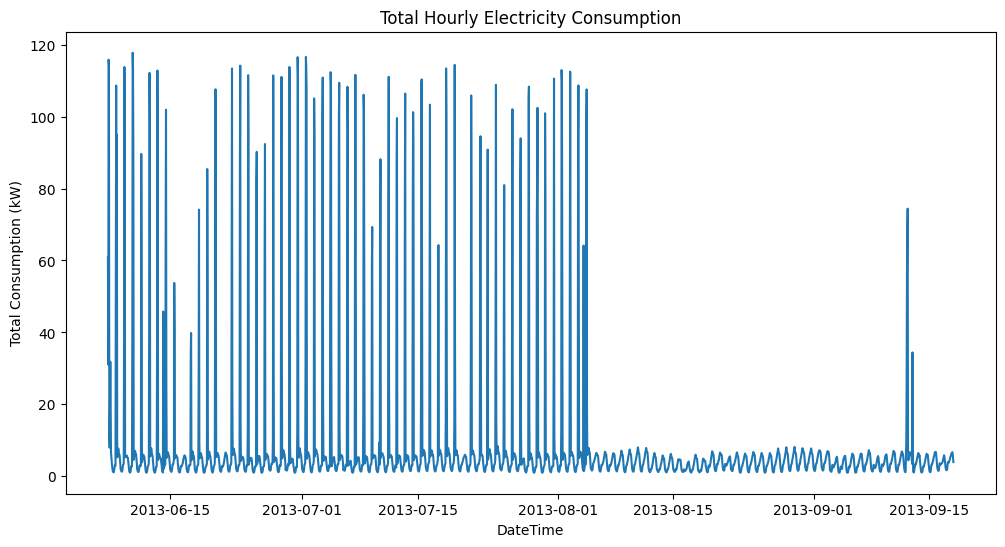

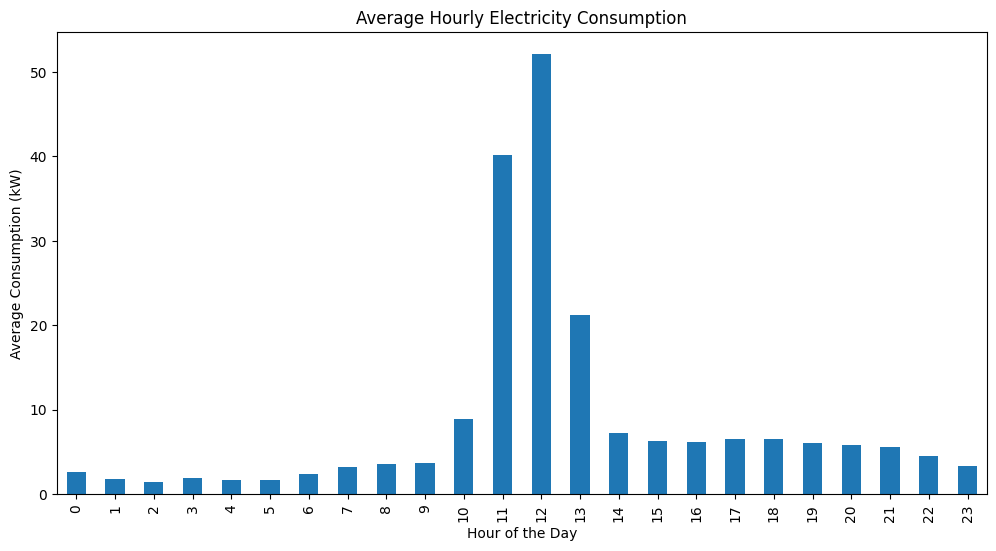

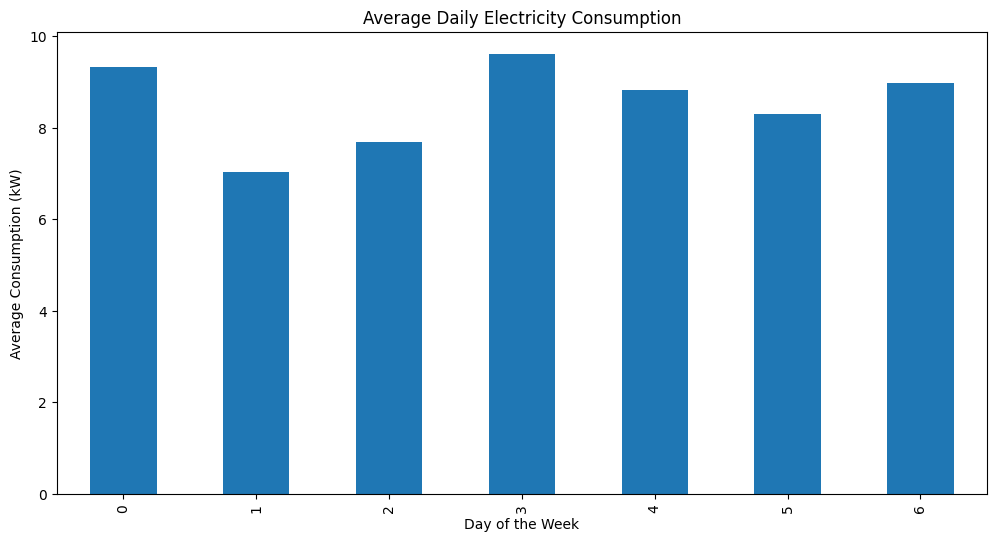

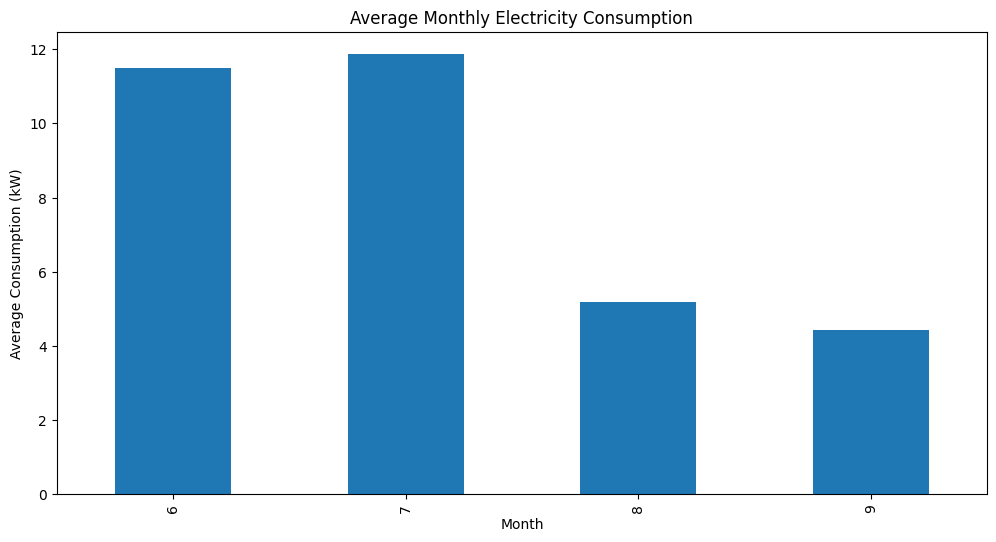

In [15]:
plot_data(merged_df)

##### Observations:

__1. Total Hourly Electricity Consumption:__

- The total hourly electricity consumption shows a clear pattern of high consumption followed by periods of low consumption.

- This pattern suggests regular cycles of electricity usage, potentially corresponding to daily or weekly routines. The spikes in consumption could be due to specific events or peak usage times, while the low periods might indicate off-peak hours or times when less electricity is needed.

__2. Average Hourly Electricity Consumption:__

- There is a significant spike in electricity consumption around the 11th and 12th hours of the day.

- The high consumption during these hours indicates peak usage times, likely corresponding to midday activities when more electrical appliances are in use. This could be related to increased cooling or heating demands, cooking activities, or other daily routines.

__3. Average Daily Electricity Consumption:__

- Electricity consumption is relatively high on Sundays (0) and decreases on Mondays (1), then stabilizes throughout the week with a slight increase towards the weekend.

- The higher consumption on Sundays could be due to more people being at home, engaging in activities that require electricity. The decrease on Mondays might indicate a shift to workplaces or schools, resulting in lower residential electricity usage. The stabilization during weekdays suggests a consistent routine, with another increase towards the weekend as people spend more time at home.

__4. Average Monthly Electricity Consumption:__

- There is a higher average electricity consumption in June and July, followed by a decrease in August and September.

- The higher consumption in June and July could be attributed to the summer months, where increased use of cooling systems, such as air conditioning, leads to higher electricity usage. The decline in August and September suggests a reduction in cooling needs as temperatures begin to moderate.

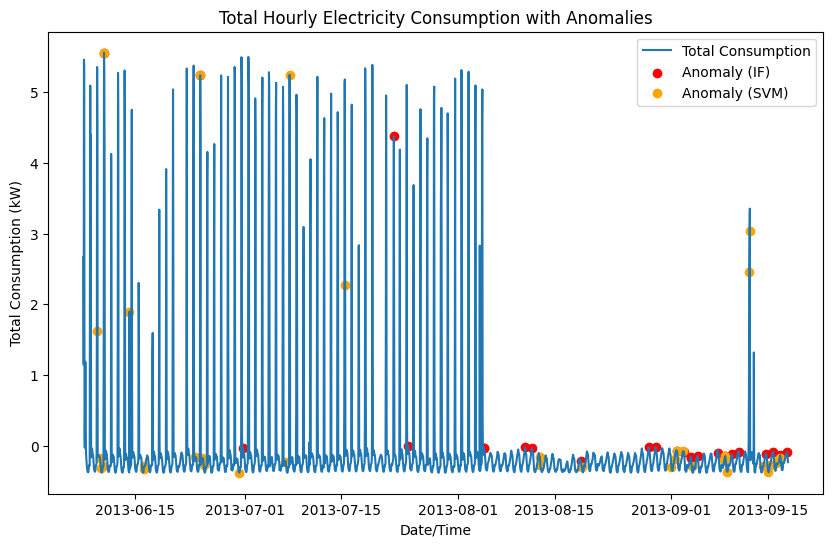

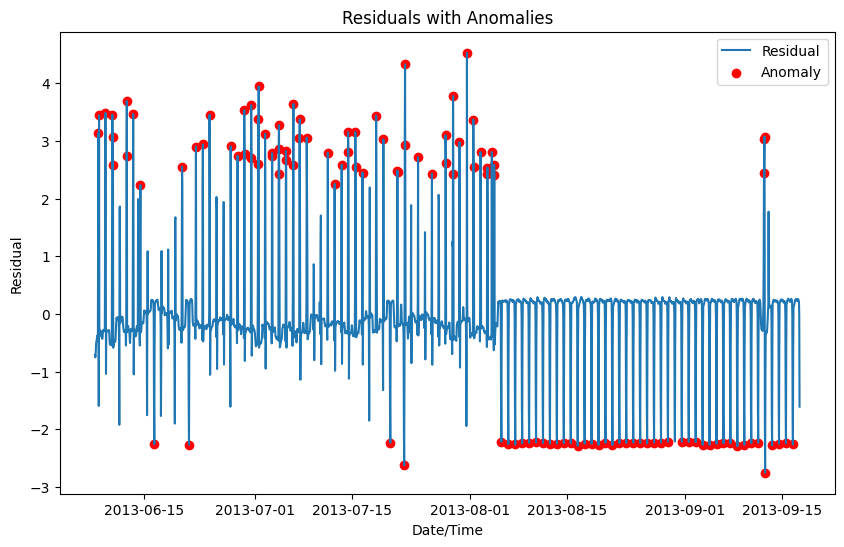

In [16]:
plot_abnormality(df_anomaly,anomalies_residual)

##### Obseravtions

__1. Total Hourly Electricity Consumption with Anomalies__

In this plot, we can observe the total hourly electricity consumption over the period from June to September 2013. The anomalies detected by the Isolation Forest (IF) and One-Class SVM (SVM) are highlighted in red and orange, respectively.

- The initial two months show a high frequency of consumption peaks, which might indicate a change in usage patterns, possible appliance malfunction, or reporting errors.
- The drop in consumption after mid-August and the spikes in September and fewer anomalies could be possibly caused by changes in usage patterns.
- There are notable anomalies detected towards the end of the period in September, suggesting a different pattern from IF.

__2. Residuals with Anomalies__

This plot shows the residuals from the seasonal decomposition of total consumption, with anomalies detected using Z-scores highlighted in red.

- The residuals represent the difference between the observed data and the combined trend and seasonal components.
- There is a strong correlation between the anomalies detected in the total consumption and the residuals, suggesting consistency in the detection methods.
- The overlapping anomalies between different methods (IF, SVM, and Z-scores) indicate robust identification of abnormal patterns.


### Assignment 3: EDA and forecast model

__Objective:__ create EDA and forecast model to predict RTLMP
We need to analyze and create predictive modeling in daily basis as quantitive analyst. Create EDA using the AS_3_file and make your model to predict RTLMP from the data.

__Data Files:__
In the data file timeseries_data.xlsx, you can find following timeseries (hourly):

- RTLoad: ERCOT real-time hourly actual load
- WIND_RTI: ERCOT real-time hourly wind generation
- GENERATION_SOLAR_RT: ERCOT real-time solar generation
- RTLMP: ERCOT North hub real-time price

__Requirements:__
- Create Exploratory Data Analysis (EDA)
- Create forecast model to predict RTLMP

__Hint:__
notice the timestamps between independent and explanatory variables

#### EDA
1. basic data processing 
2. basic plots (general, distribution, correlation)
3. exclude the extreme outliers
4. detect the time series features of the numerical variables

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot, autocorrelation_plot
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# display the full data with out truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [18]:
# baisc data preprocessing
AS3_file_path = "Assignment 3 - timeseries_data.xlsx"
AS3_file = pd.read_excel(AS3_file_path)
AS3_file_DATETIME = list(pd.to_datetime(AS3_file['DATETIME']))

AS3_file.drop(columns=['DATETIME','MARKETDAY'], inplace=True)
AS3_file.PEAKTYPE = AS3_file['PEAKTYPE'].apply(lambda x: 1 if x == 'WEPEAK' else 0)

Month_dict = dict(zip(AS3_file['MONTH'].unique(), range(1, 13)))
AS3_file.MONTH = AS3_file['MONTH'].apply(lambda x: Month_dict[x])

AS3_file.columns = ['RTLMP', 'WIND', 'SOLAR', 'LOAD', 'HOUR', 'PEAKTYPE', 'MONTH', 'YEAR']

AS3_file.head(5)

,RTLMP,WIND,SOLAR,LOAD,HOUR,PEAKTYPE,MONTH,YEAR
0,23.3575,2155.31,0.0,29485.791355,1,0,1,2017
1,21.4650,2313.81,0.0,28911.565913,2,0,1,2017
2,20.7350,2587.68,0.0,28238.258175,3,0,1,2017
3,20.2700,2748.65,0.0,27821.000513,4,0,1,2017
4,20.1200,2757.49,0.0,27646.942413,5,0,1,2017


In [19]:
print("==========info==========")
print(AS3_file.info())

==========info==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14987 entries, 0 to 14986
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   RTLMP     14987 non-null  float64
 1   WIND      14982 non-null  float64
 2   SOLAR     14983 non-null  float64
 3   LOAD      14987 non-null  float64
 4   HOUR      14987 non-null  int64  
 5   PEAKTYPE  14987 non-null  int64  
 6   MONTH     14987 non-null  int64  
 7   YEAR      14987 non-null  int64  
dtypes: float64(4), int64(4)
memory usage: 936.8 KB
None


In [20]:
print("==========describe==========")
print(AS3_file.describe())

==========describe==========
              RTLMP          WIND         SOLAR          LOAD          HOUR  \
count  14987.000000  14982.000000  14983.000000  14987.000000  14987.000000   
mean      25.766417   7532.436283    291.989714  42371.673703     12.495763   
std       46.361945   3992.884834    370.914596   9874.339631      6.922309   
min      -17.860000     54.440000      0.000000  25566.511248      1.000000   
25%       18.041250   4135.630000      0.000000  35431.636526      6.000000   
50%       20.057500   7281.445000     22.150000  39934.007113     12.000000   
75%       25.030000  10851.647500    608.635000  47873.100786     18.000000   
max     2809.357500  20350.400000   1257.540000  73264.662123     24.000000   

           PEAKTYPE         MONTH          YEAR  
count  14987.000000  14987.000000  14987.000000  
mean       0.201775      5.814172   2017.415493  
std        0.401338      3.195292      0.492823  
min        0.000000      1.000000   2017.000000  
25%      

In [21]:
print("==========null values==========")
print(AS3_file.isnull().sum())

def fill_null_with_average(df):
    for col in df.columns:
        for i in range(len(df)):
            if pd.isnull(df.at[i, col]):
                above = df.loc[:i-1, col].dropna()
                above_value = above.iloc[-1] if not above.empty else None
                
                below = df.loc[i+1:, col].dropna()
                below_value = below.iloc[0] if not below.empty else None
                
                if above_value is not None and below_value is not None:
                    df.at[i, col] = (above_value + below_value) / 2
                elif above_value is not None:
                    df.at[i, col] = above_value
                elif below_value is not None:
                    df.at[i, col] = below_value
                else:
                    df.at[i, col] = 0 

    return df

print("==========fill null values==========")
AS3_file = fill_null_with_average(AS3_file.copy())
print(AS3_file.isnull().sum())

==========null values==========
RTLMP       0
WIND        5
SOLAR       4
LOAD        0
HOUR        0
PEAKTYPE    0
MONTH       0
YEAR        0
dtype: int64
==========fill null values==========
RTLMP       0
WIND        0
SOLAR       0
LOAD        0
HOUR        0
PEAKTYPE    0
MONTH       0
YEAR        0
dtype: int64


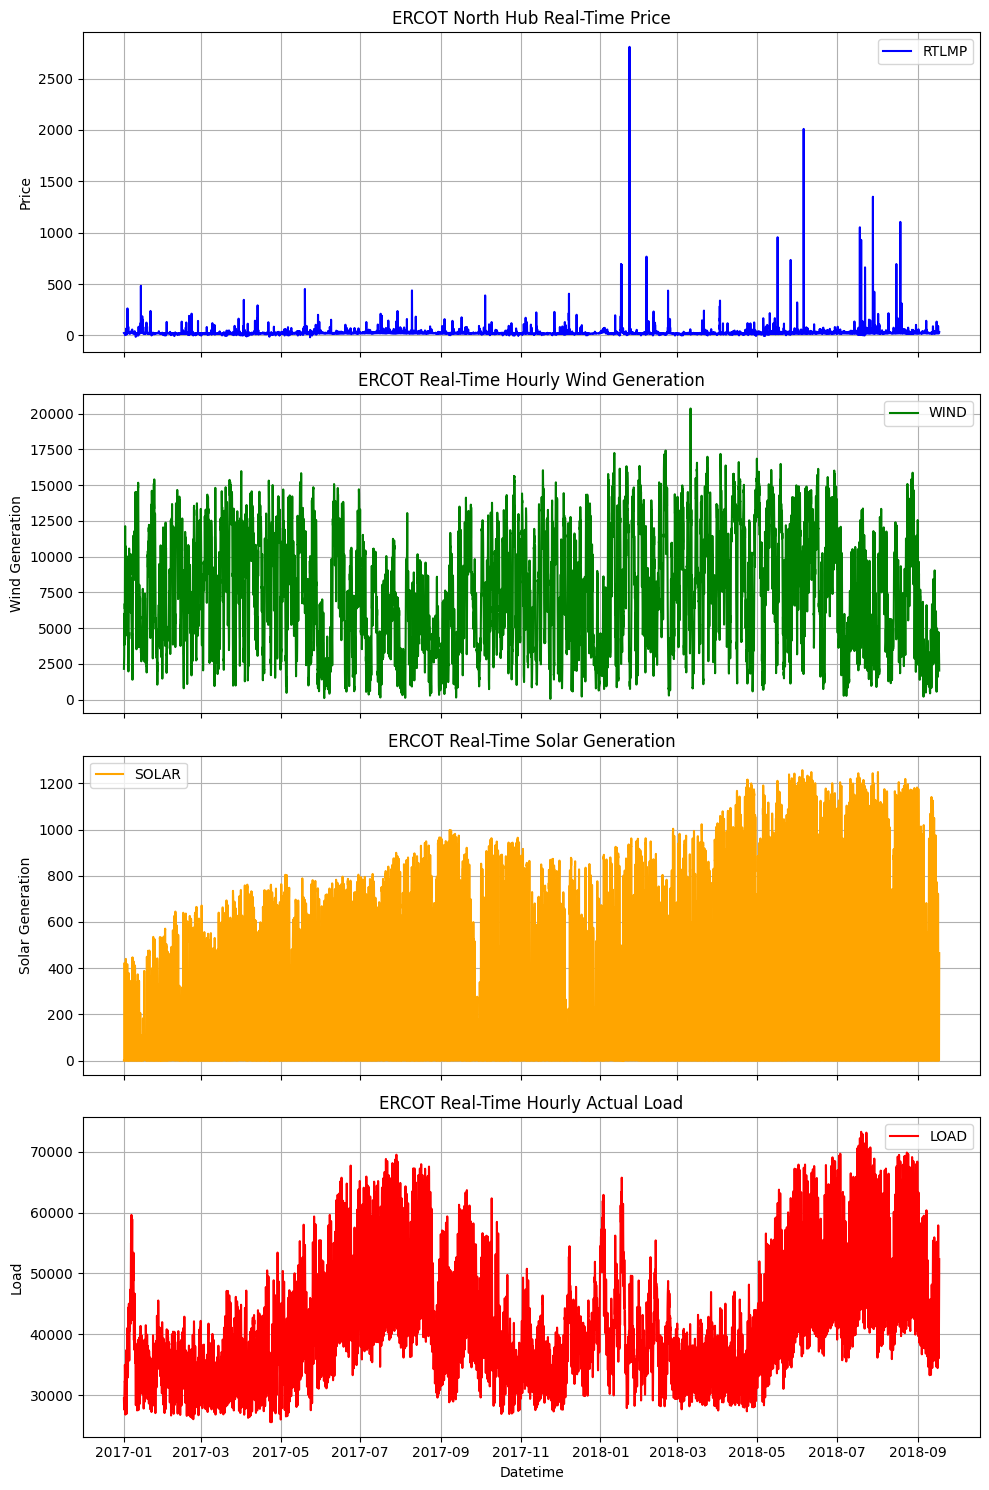

In [22]:
# basic plots

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 15), sharex=True)

# Plot for HB_NORTH (RTLMP)
axes[0].plot(AS3_file_DATETIME , AS3_file['RTLMP'], label='RTLMP', color='blue')
axes[0].set_ylabel('Price')
axes[0].set_title('ERCOT North Hub Real-Time Price')
axes[0].legend()
axes[0].grid(True)

# Plot for ERCOT (WIND_RTI)
axes[1].plot(AS3_file_DATETIME , AS3_file['WIND'], label='WIND', color='green')
axes[1].set_ylabel('Wind Generation')
axes[1].set_title('ERCOT Real-Time Hourly Wind Generation')
axes[1].legend()
axes[1].grid(True)

# Plot for ERCOT (GENERATION_SOLAR_RT)
axes[2].plot(AS3_file_DATETIME , AS3_file['SOLAR'], label='SOLAR', color='orange')
axes[2].set_ylabel('Solar Generation')
axes[2].set_title('ERCOT Real-Time Solar Generation')
axes[2].legend()
axes[2].grid(True)

# Plot for ERCOT (RTLOAD)
axes[3].plot(AS3_file_DATETIME , AS3_file['LOAD'], label='LOAD', color='red')
axes[3].set_ylabel('Load')
axes[3].set_title('ERCOT Real-Time Hourly Actual Load')
axes[3].set_xlabel('Datetime')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()

__Observations__

1. __ERCOT North Hub Real-Time Price Over Time__: 
There are several significant spikes with extreme values in the price, which may be due to special events or market anomalies and need further analysis to understand the causes. Most of the time, the price remains relatively low, indicating normal market fluctuations.Thus, removing the extreme outliers might be implemented for better forcast performance.

2. __ERCOT Real-Time Hourly Wind Generation Over Time__:
The wind generation fluctuates greatly over the entire period without a significant trend or seasonality, but the value is relatively stable without noticeable outliers.

3. __ERCOT Real-Time Solar Generation Over Time__:
There is an increasing trend in solar generation over time, which may be due to seasonal changes or gradual deployment of solar panels. If we look closer to the solar generation data, we can see the daily seansonality in the column.

4. __ERCOT Real-Time Hourly Actual Load Over Time__:
There is a clear seasonal pattern in the load, with higher values in summer and winter, likely due to heating and cooling demands and need to analyze the reasons behind the load variations.

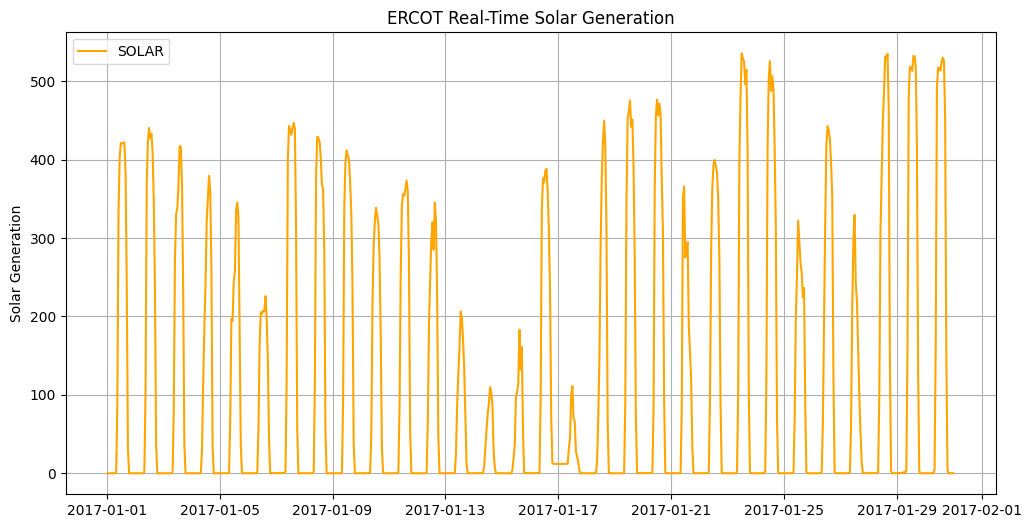

In [23]:
plt.figure(figsize=(12, 6))
# Plot for ERCOT (GENERATION_SOLAR_RT)
plt.plot(AS3_file_DATETIME[:720], AS3_file[:720]['SOLAR'], label='SOLAR', color='orange')
plt.ylabel('Solar Generation')
plt.title('ERCOT Real-Time Solar Generation')
plt.legend()
plt.grid(True)

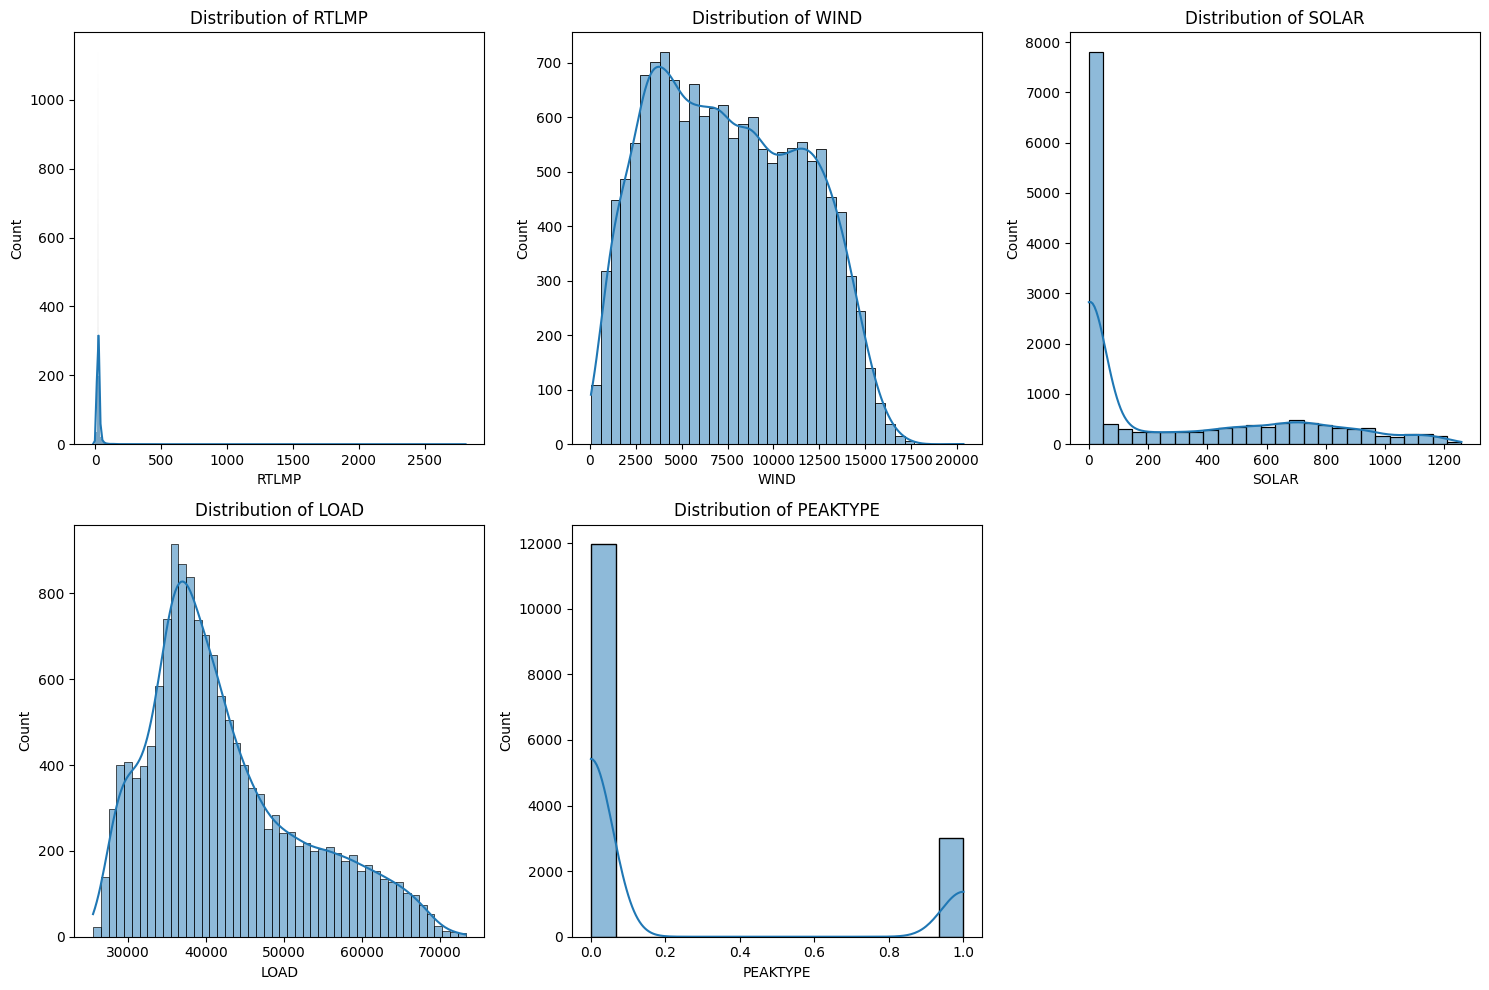

In [24]:
numerical_columns = ['RTLMP', 'WIND', 'SOLAR', 'LOAD', 'PEAKTYPE']
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(AS3_file[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

__Observations__

 The price distribution is highly skewed, with most values clustered at low prices but some extreme high values. The wind generation distribution and The actual load distribution is roughly symmetrical, showing a trend towards a normal distribution. The solar generation distribution is apparently left-skewed, with most values being low, indicating generation may be limited by weather conditions.

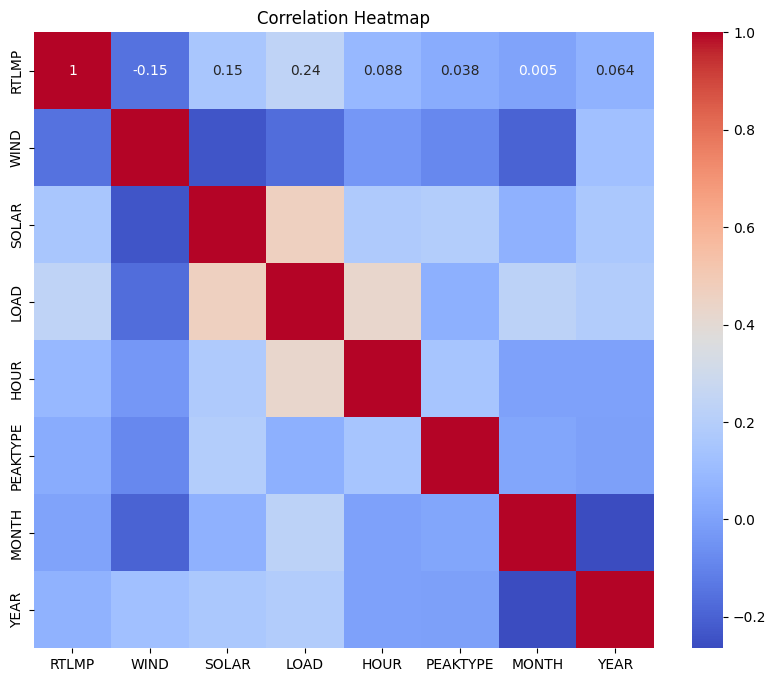

In [25]:
plt.figure(figsize=(10, 8))
sns.heatmap(AS3_file.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

__Observations__
- HB_NORTH (RTLMP) has low correlation with variables such as hour, peaktype, month and year, indicating the feasibility of removing these columns when training the model and predicting. 
- There is a certain negative correlation between ERCOT (WIND_RTI) and ERCOT (GENERATION_SOLAR_RT), possibly due to the complementary effect of wind and solar generation under different weather conditions.

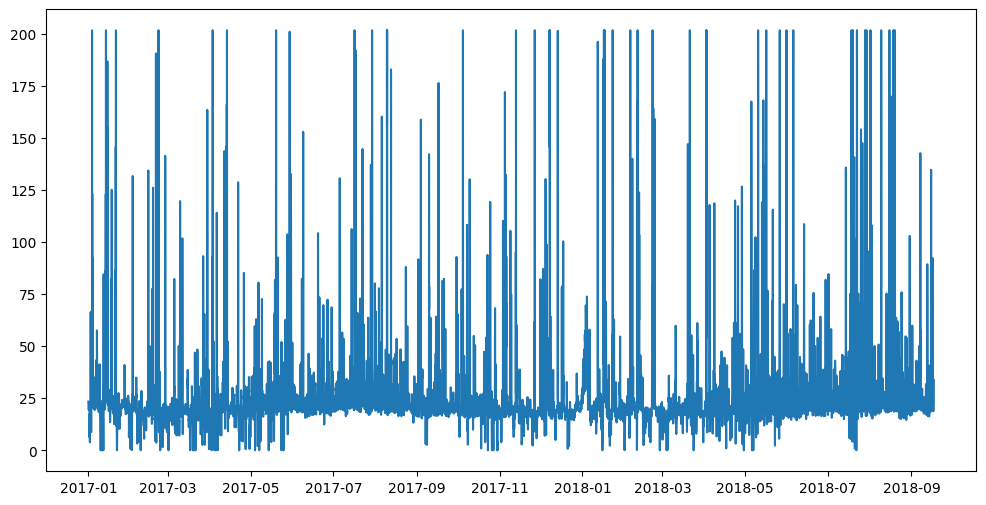

In [26]:
#  Winsorisation to remove outliers
def winsorize_series(s):
    lower_bound = s.quantile(0.005)
    upper_bound = s.quantile(0.995)
    s[s < lower_bound] = lower_bound
    s[s > upper_bound] = upper_bound
    return s

plt.figure(figsize=(12, 6))
# AS3_file['RTLMP'] = winsorize_series(AS3_file.copy()['RTLMP'])
plt.plot(AS3_file_DATETIME, winsorize_series(AS3_file.copy()['RTLMP']), label='RTLMP')

AS3_file['RTLMP'] = winsorize_series(AS3_file.copy()['RTLMP'])


Analyzing RTLMP...


Analyzing WIND...


Analyzing SOLAR...


Analyzing LOAD...



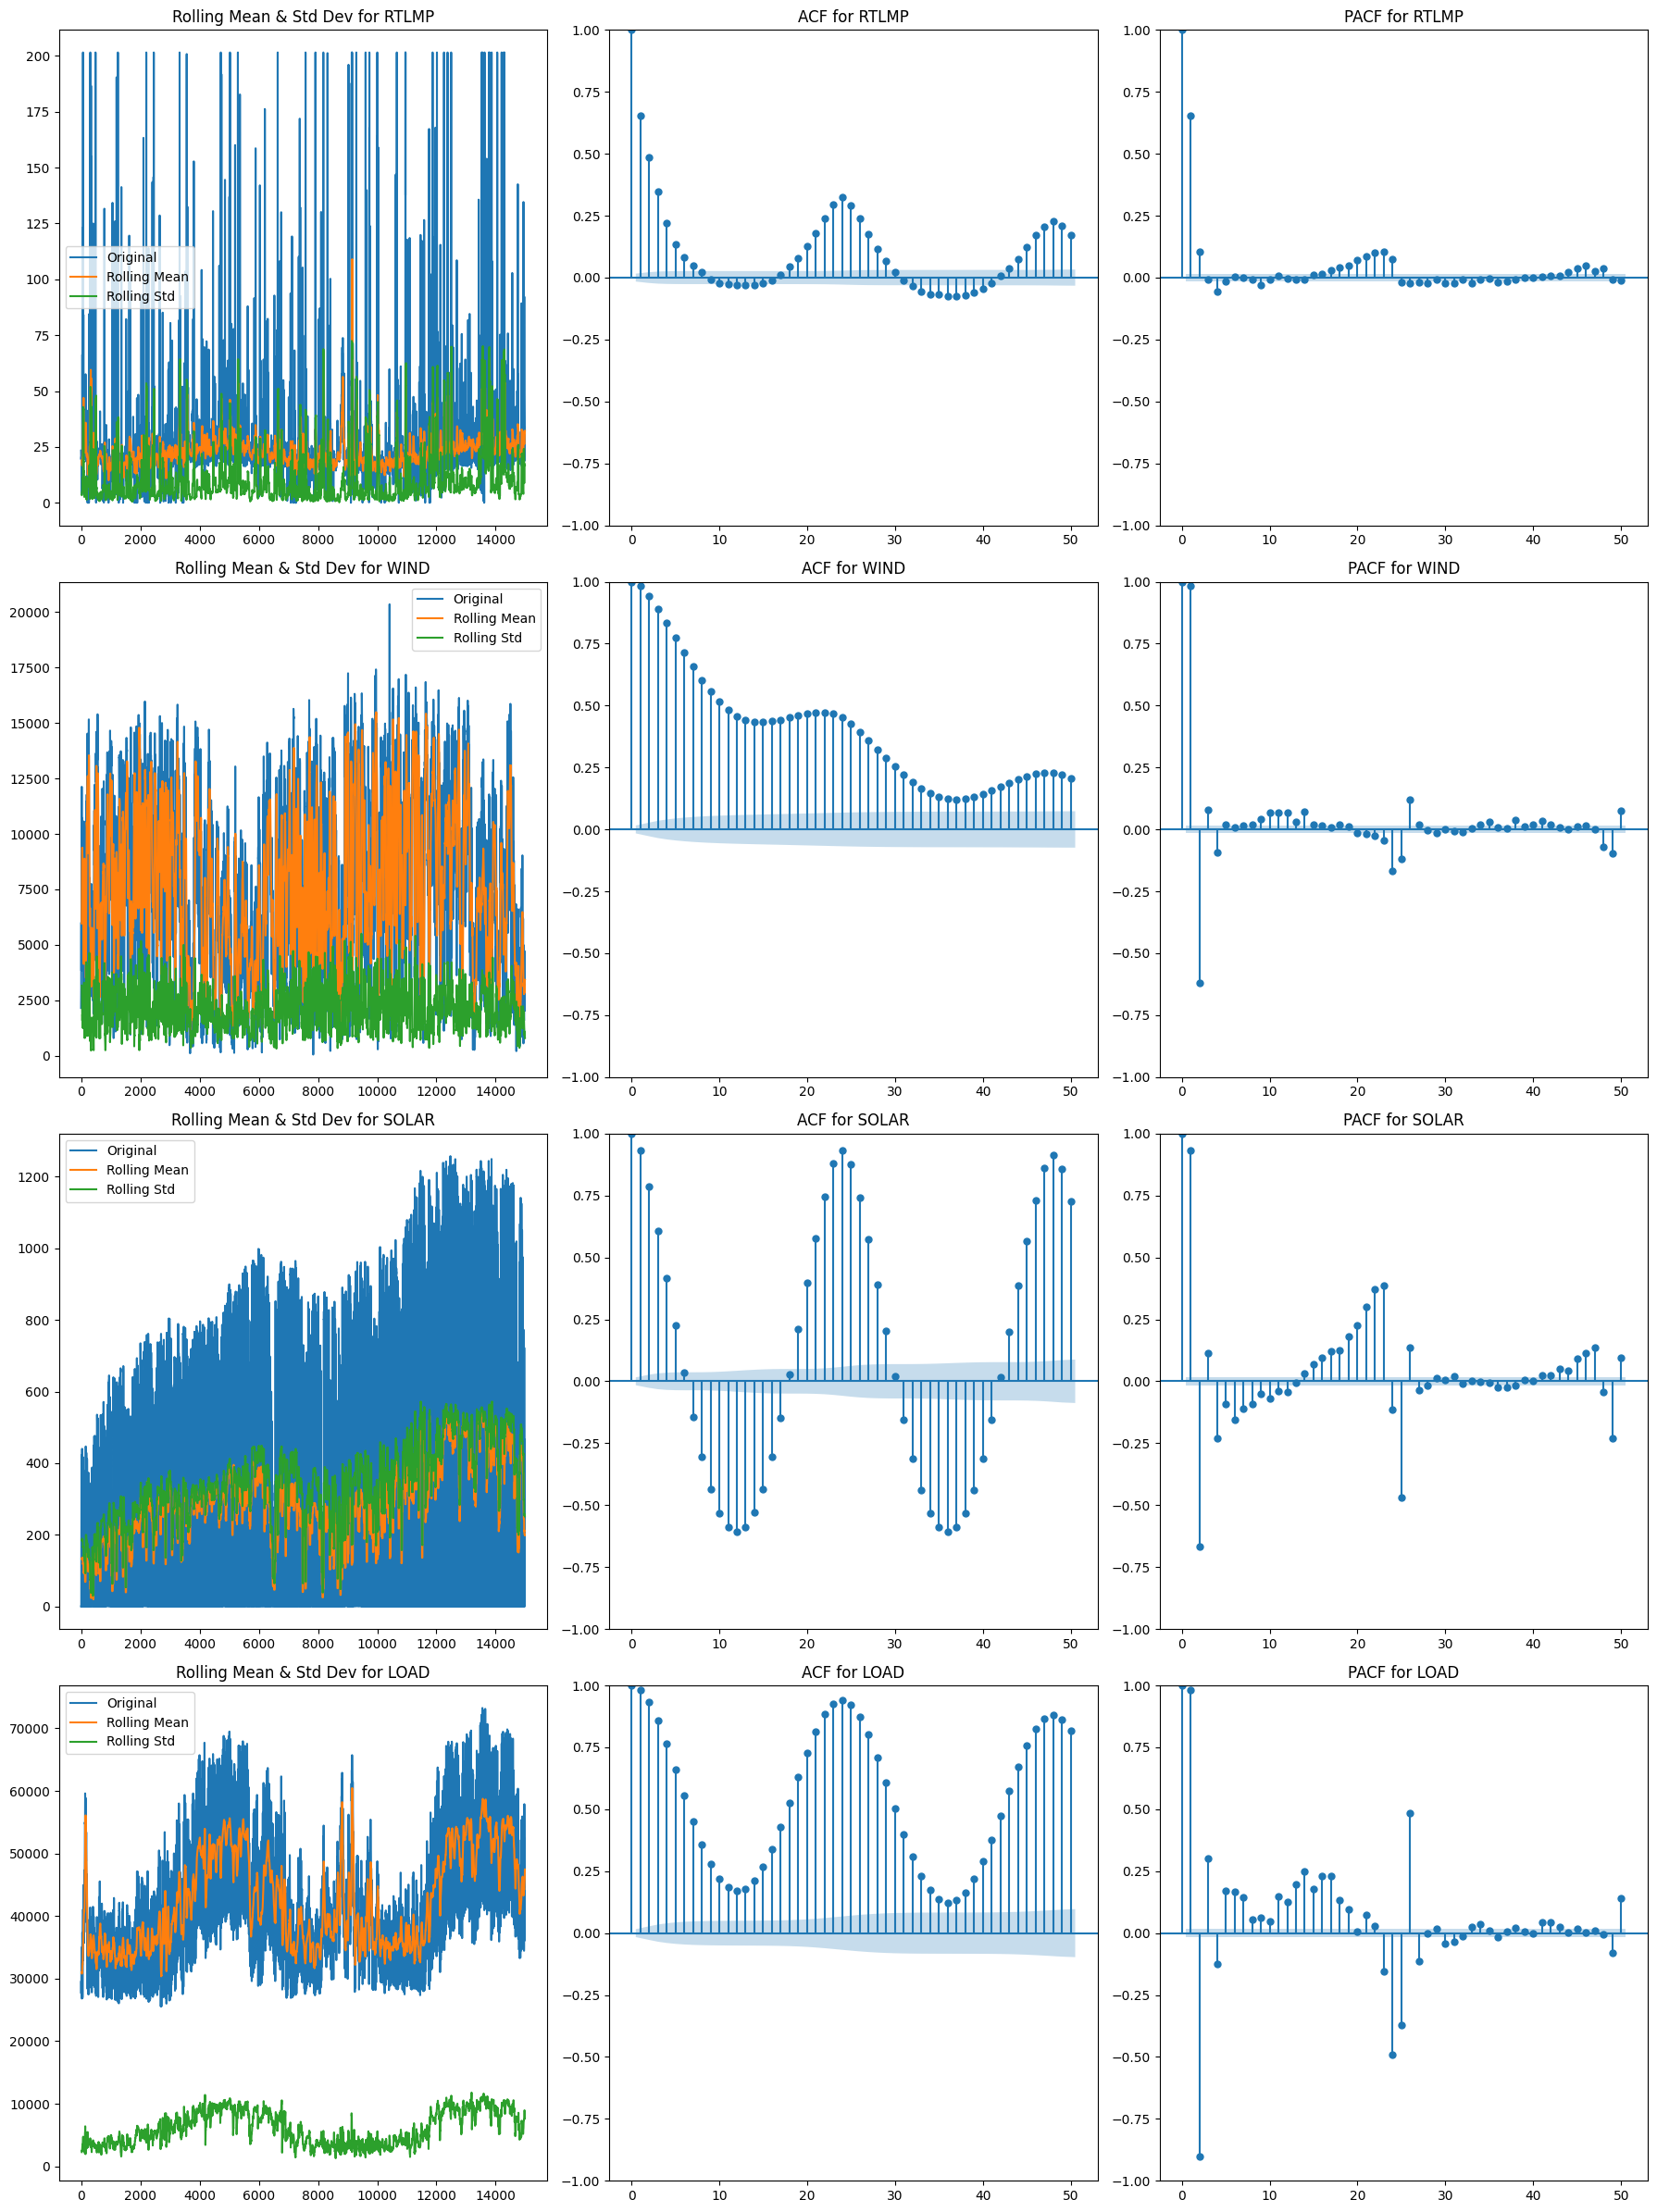

RTLMP is stationary based on the Dickey-Fuller test.
WIND is stationary based on the Dickey-Fuller test.
SOLAR is stationary based on the Dickey-Fuller test.
LOAD is stationary based on the Dickey-Fuller test.


In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error


def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    p_value = dftest[1]
    return p_value

def plot_rolling_statistics(timeseries, column_name, ax):
    rolmean = timeseries.rolling(window=24).mean()
    rolstd = timeseries.rolling(window=24).std()

    ax.plot(timeseries, label='Original')
    ax.plot(rolmean, label='Rolling Mean')
    ax.plot(rolstd, label='Rolling Std')
    ax.set_title(f'Rolling Mean & Std Dev for {column_name}')
    ax.legend()

def plot_acf_pacf(timeseries, column_name, axs):
    plot_acf(timeseries, lags=50, ax=axs[0])
    axs[0].set_title(f'ACF for {column_name}')
    plot_pacf(timeseries, lags=50, ax=axs[1])
    axs[1].set_title(f'PACF for {column_name}')

columns = ['RTLMP', 'WIND', 'SOLAR', 'LOAD']
stationarity_results = {}

fig, axes = plt.subplots(len(columns), 3, figsize=(18, 24))

for i, column in enumerate(columns):
    print(f'\nAnalyzing {column}...\n')
    p_value = test_stationarity(AS3_file[column])
    stationarity_results[column] = p_value < 0.05

    plot_rolling_statistics(AS3_file[column], column, axes[i, 0])
    plot_acf_pacf(AS3_file[column], column, axes[i, 1:])

plt.tight_layout()
plt.show()

# Print stationarity results
for column, is_stationary in stationarity_results.items():
    print(f'{column} is {"stationary" if is_stationary else "not stationary"} based on the Dickey-Fuller test.')

##### Observations:
The series is __stationary__ but ACF and PACF plots for all four columns suggest that the data has a __seasonal component__ and some __trend__. Thus, it can be wise to choose a model with better performance in time series.

#### LSTM Prediction Model

As found from EDA, the data is a time series with extreme outliers more than 2500. And the correlation heatmap shows that except hour, other categorical time variables are with low correlation with the dependent variable we intend to predict. 

Thus, given all the features we discovered. I choose __LSTM__ to perform prediction, which is known for the solid performance in time series. And I also ignore the time categorical variables, leaving only hour and numerical variables `WIND` `SOLAR` `LOAD`. The initial metrics is: rmse(17.425) mae(5.189).

Then, I went through the gridsearch, although no big change in the overall performance, I got the graph with both the lowest rmse(16.7) and mae(5.1).

##### Feature Engineering

##### Basic: LSTM

In [29]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), AS3_file.columns

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names_ = [('%s(t-%d)' % (names[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names_ += [('%s(t)' % (names[j])) for j in range(n_vars)]
        else:
            names_ += [('%s(t+%d)' % (names[j], i)) for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names_
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [30]:
# Normalize the data and convert to time series data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(AS3_file.iloc[:,:5].values)

AS3_data = series_to_supervised(scaled, 1, 1)
AS3_data.drop(AS3_data.columns[-4:], axis=1, inplace=True)
AS3_data[:10]
#AS3_data.drop( AS3_data.columns[range(8, 16)], axis=1, inplace=True)

,RTLMP(t-1),WIND(t-1),SOLAR(t-1),LOAD(t-1),HOUR(t-1),RTLMP(t)
1,0.115877,0.103512,0.000000,0.082168,0.000000,0.106487
2,0.106487,0.111321,0.000000,0.070130,0.043478,0.102865
3,0.102865,0.124815,0.000000,0.056014,0.086957,0.100558
4,0.100558,0.132746,0.000000,0.047266,0.130435,0.099814
5,0.099814,0.133182,0.000000,0.043617,0.173913,0.098189
6,0.098189,0.146710,0.000000,0.044762,0.217391,0.097842
7,0.097842,0.185705,0.000000,0.056142,0.260870,0.097916
8,0.097916,0.215089,0.000429,0.071060,0.304348,0.095559
9,0.095559,0.293400,0.069342,0.085048,0.347826,0.098536
10,0.098536,0.248978,0.265137,0.107160,0.391304,0.101129


In [31]:
# split into train and test sets
values = AS3_data.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 5) (8760,) (6226, 1, 5) (6226,)


Epoch 1/50


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


122/122 - 1s - 7ms/step - loss: 0.0341 - val_loss: 0.0383
Epoch 2/50
122/122 - 0s - 1ms/step - loss: 0.0225 - val_loss: 0.0395
Epoch 3/50
122/122 - 0s - 1ms/step - loss: 0.0217 - val_loss: 0.0374
Epoch 4/50
122/122 - 0s - 1ms/step - loss: 0.0213 - val_loss: 0.0362
Epoch 5/50
122/122 - 0s - 1ms/step - loss: 0.0211 - val_loss: 0.0350
Epoch 6/50
122/122 - 0s - 1ms/step - loss: 0.0208 - val_loss: 0.0341
Epoch 7/50
122/122 - 0s - 1ms/step - loss: 0.0205 - val_loss: 0.0335
Epoch 8/50
122/122 - 0s - 1ms/step - loss: 0.0203 - val_loss: 0.0323
Epoch 9/50
122/122 - 0s - 1ms/step - loss: 0.0201 - val_loss: 0.0317
Epoch 10/50
122/122 - 0s - 1ms/step - loss: 0.0200 - val_loss: 0.0312
Epoch 11/50
122/122 - 0s - 1ms/step - loss: 0.0198 - val_loss: 0.0309
Epoch 12/50
122/122 - 0s - 1ms/step - loss: 0.0197 - val_loss: 0.0305
Epoch 13/50
122/122 - 0s - 1ms/step - loss: 0.0196 - val_loss: 0.0302
Epoch 14/50
122/122 - 0s - 1ms/step - loss: 0.0194 - val_loss: 0.0297
Epoch 15/50
122/122 - 0s - 1ms/step - lo

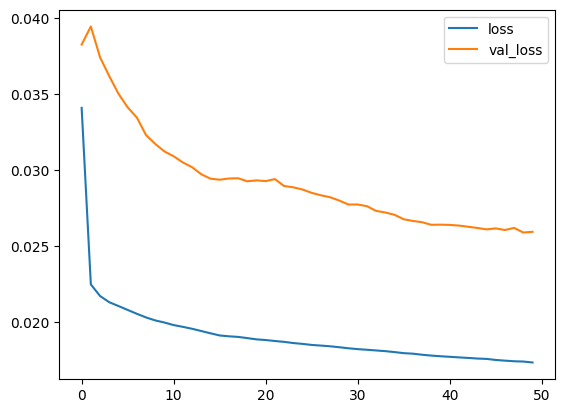

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
Test RMSE: 17.414
Test MAE: 5.229


In [32]:
from matplotlib import pyplot

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='loss')
pyplot.plot(history.history['val_loss'], label='val_loss')
pyplot.legend()
pyplot.show()

from math import sqrt
from numpy import concatenate
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

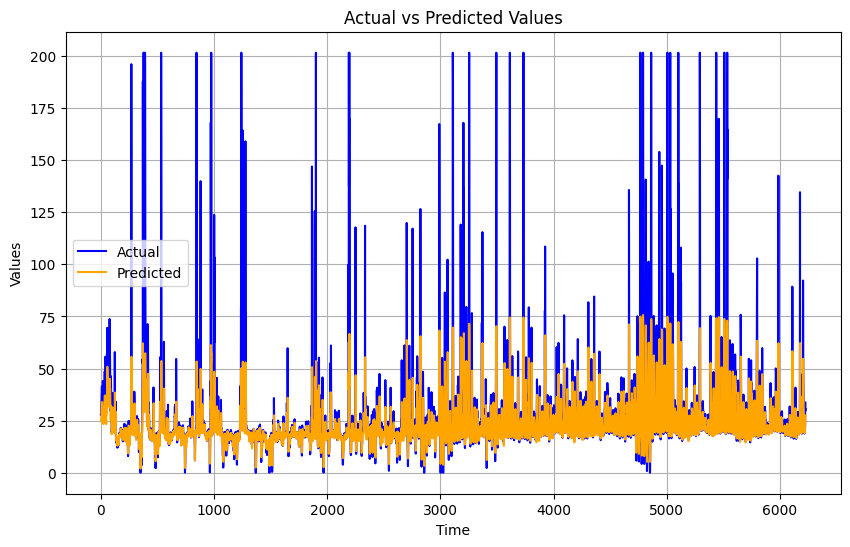

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(inv_y, label='Actual', color='blue')
plt.plot(inv_yhat, label='Predicted', color='orange')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

##### Gridsearch

In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(AS3_file.iloc[:,:5].values)

AS3_data = series_to_supervised(scaled, 1, 1)
AS3_data.drop(AS3_data.columns[-4:], axis=1, inplace=True)
AS3_data

# split into train and test sets
values = AS3_data.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [35]:
from tqdm import tqdm
from math import sqrt
      
# Function to create the LSTM model
def create_model(units=50, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer=optimizer)
    return model

# Function to evaluate model performance
def evaluate_model(train_X, train_y, test_X, test_y, units, batch_size, epochs, optimizer):
    model = create_model(units, optimizer)
    model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False, validation_data=(test_X, test_y))
    
    # Make predictions
    yhat = model.predict(test_X)
    test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    
    # Invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test_X_reshaped[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    
    # Invert scaling for actual
    test_y_reshaped = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y_reshaped, test_X_reshaped[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
    # Calculate RMSE and MAE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    mae = mean_absolute_error(inv_y, inv_yhat)
    
    return rmse, mae

# Function to search for the best hyperparameters
def search_best_hyperparameters():
    # Define hyperparameters to test
    units_list = [50, 100, 150]
    batch_size_list = [32, 64, 128]
    epochs_list = [10, 20, 50]
    optimizer_list = ['adam', 'sgd']

    # Initialize results storage
    results = []

    # Calculate total iterations for tqdm progress bar
    total_iterations = len(units_list) * len(batch_size_list) * len(epochs_list) * len(optimizer_list)

    # Manually test different hyperparameters with tqdm progress bar
    with tqdm(total=total_iterations, desc="Hyperparameter Search") as pbar:
        for units in units_list:
            for batch_size in batch_size_list:
                for epochs in epochs_list:
                    for optimizer in optimizer_list:
                        rmse, mae = evaluate_model(train_X, train_y, test_X, test_y, units, batch_size, epochs, optimizer)
                        results.append((units, batch_size, epochs, optimizer, rmse, mae))
                        print(f"Tested (units={units}, batch_size={batch_size}, epochs={epochs}, optimizer={optimizer}): RMSE={rmse}, MAE={mae}")
                        pbar.update(1)
    
    return results

def train_and_plot_best_model(results, train_X, train_y, test_X, test_y, metric='mae'):
    if metric == 'mae':
        best_result = min(results, key=lambda x: x[5])  # Sort by MAE
    elif metric == 'rmse':
        best_result = min(results, key=lambda x: x[4])  # Sort by RMSE
    else:
        raise ValueError("Unsupported metric. Use 'mae' or 'rmse'.")
    
    print(f"Best hyperparameters: units={best_result[0]}, batch_size={best_result[1]}, epochs={best_result[2]}, optimizer={best_result[3]}")
    print(f"Best RMSE={best_result[4]}, Best MAE={best_result[5]}")

    best_units, best_batch_size, best_epochs, best_optimizer = best_result[:4]
    model = create_model(best_units, best_optimizer)
    history = model.fit(train_X, train_y, epochs=best_epochs, batch_size=best_batch_size, validation_data=(test_X, test_y), verbose=0, shuffle=False)

    # Plot history
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

    # Make final prediction and plot results
    yhat = model.predict(test_X, verbose=0)
    test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    # Invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test_X_reshaped[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:, 0]

    # Invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X_reshaped[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:, 0]

    # Plot the actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(inv_y, label='Actual', color='blue')
    plt.plot(inv_yhat, label='Predicted', color='orange')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()


In [36]:
# Example usage
results = search_best_hyperparameters()

Hyperparameter Search:   0%|          | 0/54 [00:00<?, ?it/s]/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step


Hyperparameter Search:   2%|▏         | 1/54 [00:03<02:54,  3.28s/it]

Tested (units=50, batch_size=32, epochs=10, optimizer=adam): RMSE=17.568129764541112, MAE=6.679500400418448


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step


Hyperparameter Search:   4%|▎         | 2/54 [00:06<02:39,  3.06s/it]

Tested (units=50, batch_size=32, epochs=10, optimizer=sgd): RMSE=20.467162656802635, MAE=6.710483769764226


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step


Hyperparameter Search:   6%|▌         | 3/54 [00:11<03:38,  4.29s/it]

Tested (units=50, batch_size=32, epochs=20, optimizer=adam): RMSE=17.311661685256414, MAE=6.023261004072625


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step


Hyperparameter Search:   7%|▋         | 4/54 [00:16<03:43,  4.47s/it]

Tested (units=50, batch_size=32, epochs=20, optimizer=sgd): RMSE=19.3211530796083, MAE=6.223597507531967


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step


Hyperparameter Search:   9%|▉         | 5/54 [00:28<05:50,  7.15s/it]

Tested (units=50, batch_size=32, epochs=50, optimizer=adam): RMSE=18.08365428064223, MAE=5.214863162718127


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step


Hyperparameter Search:  11%|█         | 6/54 [00:38<06:35,  8.25s/it]

Tested (units=50, batch_size=32, epochs=50, optimizer=sgd): RMSE=18.61805892558348, MAE=5.927090706274953


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step


Hyperparameter Search:  13%|█▎        | 7/54 [00:41<04:54,  6.27s/it]

Tested (units=50, batch_size=64, epochs=10, optimizer=adam): RMSE=17.15223947665057, MAE=5.837578390433783


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step


Hyperparameter Search:  15%|█▍        | 8/54 [00:42<03:43,  4.85s/it]

Tested (units=50, batch_size=64, epochs=10, optimizer=sgd): RMSE=20.995410134633445, MAE=6.878991423441863


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step


Hyperparameter Search:  17%|█▋        | 9/54 [00:46<03:20,  4.46s/it]

Tested (units=50, batch_size=64, epochs=20, optimizer=adam): RMSE=16.757869175681925, MAE=5.634310302324293


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step


Hyperparameter Search:  19%|█▊        | 10/54 [00:49<02:56,  4.00s/it]

Tested (units=50, batch_size=64, epochs=20, optimizer=sgd): RMSE=20.072876944693185, MAE=6.466181807955457


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step


Hyperparameter Search:  20%|██        | 11/54 [00:56<03:35,  5.02s/it]

Tested (units=50, batch_size=64, epochs=50, optimizer=adam): RMSE=17.69188837212529, MAE=5.306392059827881


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step


Hyperparameter Search:  22%|██▏       | 12/54 [01:03<03:48,  5.45s/it]

Tested (units=50, batch_size=64, epochs=50, optimizer=sgd): RMSE=19.634191304285626, MAE=6.397464213141207


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step


Hyperparameter Search:  24%|██▍       | 13/54 [01:05<02:58,  4.35s/it]

Tested (units=50, batch_size=128, epochs=10, optimizer=adam): RMSE=18.022965902383337, MAE=6.314973224807189


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step


Hyperparameter Search:  26%|██▌       | 14/54 [01:07<02:25,  3.64s/it]

Tested (units=50, batch_size=128, epochs=10, optimizer=sgd): RMSE=22.03047577298923, MAE=8.114818606172186


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step


Hyperparameter Search:  28%|██▊       | 15/54 [01:09<02:11,  3.37s/it]

Tested (units=50, batch_size=128, epochs=20, optimizer=adam): RMSE=17.412069379212614, MAE=6.131936480552912


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step


Hyperparameter Search:  30%|██▉       | 16/54 [01:12<01:55,  3.04s/it]

Tested (units=50, batch_size=128, epochs=20, optimizer=sgd): RMSE=21.623037937715548, MAE=7.071331111186581


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step


Hyperparameter Search:  31%|███▏      | 17/54 [01:17<02:21,  3.84s/it]

Tested (units=50, batch_size=128, epochs=50, optimizer=adam): RMSE=16.94094549768144, MAE=5.613632411480484


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step


Hyperparameter Search:  33%|███▎      | 18/54 [01:23<02:38,  4.41s/it]

Tested (units=50, batch_size=128, epochs=50, optimizer=sgd): RMSE=20.257720174552567, MAE=6.637965761967156


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


Hyperparameter Search:  35%|███▌      | 19/54 [01:27<02:33,  4.39s/it]

Tested (units=100, batch_size=32, epochs=10, optimizer=adam): RMSE=17.602898980987508, MAE=6.671846593711729


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step


Hyperparameter Search:  37%|███▋      | 20/54 [01:31<02:24,  4.25s/it]

Tested (units=100, batch_size=32, epochs=10, optimizer=sgd): RMSE=20.164796742354724, MAE=6.519094033257842


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step


Hyperparameter Search:  39%|███▉      | 21/54 [01:39<02:53,  5.26s/it]

Tested (units=100, batch_size=32, epochs=20, optimizer=adam): RMSE=17.384192497530957, MAE=5.971821339459942


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step


Hyperparameter Search:  41%|████      | 22/54 [01:45<02:57,  5.55s/it]

Tested (units=100, batch_size=32, epochs=20, optimizer=sgd): RMSE=19.525357439448424, MAE=6.334369884044076


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step


Hyperparameter Search:  43%|████▎     | 23/54 [02:03<04:47,  9.28s/it]

Tested (units=100, batch_size=32, epochs=50, optimizer=adam): RMSE=18.14069917682319, MAE=5.151632671052773


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step


Hyperparameter Search:  44%|████▍     | 24/54 [02:18<05:31, 11.03s/it]

Tested (units=100, batch_size=32, epochs=50, optimizer=sgd): RMSE=18.575460218371877, MAE=5.995922133698025


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step


Hyperparameter Search:  46%|████▋     | 25/54 [02:22<04:15,  8.83s/it]

Tested (units=100, batch_size=64, epochs=10, optimizer=adam): RMSE=17.29592298364995, MAE=5.8910557840984135


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step


Hyperparameter Search:  48%|████▊     | 26/54 [02:24<03:14,  6.93s/it]

Tested (units=100, batch_size=64, epochs=10, optimizer=sgd): RMSE=21.07015057155812, MAE=6.8638183471127014


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


Hyperparameter Search:  50%|█████     | 27/54 [02:30<02:53,  6.42s/it]

Tested (units=100, batch_size=64, epochs=20, optimizer=adam): RMSE=17.10755037059547, MAE=5.84771685547124


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step


Hyperparameter Search:  52%|█████▏    | 28/54 [02:34<02:29,  5.74s/it]

Tested (units=100, batch_size=64, epochs=20, optimizer=sgd): RMSE=20.41745813789273, MAE=6.780612471466661


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step


Hyperparameter Search:  54%|█████▎    | 29/54 [02:44<02:56,  7.07s/it]

Tested (units=100, batch_size=64, epochs=50, optimizer=adam): RMSE=17.756441984654824, MAE=5.336931227146212


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step


Hyperparameter Search:  56%|█████▌    | 30/54 [02:53<03:03,  7.64s/it]

Tested (units=100, batch_size=64, epochs=50, optimizer=sgd): RMSE=19.0768041859814, MAE=6.204362296942756


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step


Hyperparameter Search:  57%|█████▋    | 31/54 [02:55<02:18,  6.01s/it]

Tested (units=100, batch_size=128, epochs=10, optimizer=adam): RMSE=18.165160683099632, MAE=6.664256466731485


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step


Hyperparameter Search:  59%|█████▉    | 32/54 [02:57<01:45,  4.77s/it]

Tested (units=100, batch_size=128, epochs=10, optimizer=sgd): RMSE=21.818644082330398, MAE=7.39471051223326


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step


Hyperparameter Search:  61%|██████    | 33/54 [03:01<01:32,  4.40s/it]

Tested (units=100, batch_size=128, epochs=20, optimizer=adam): RMSE=17.605418497015844, MAE=6.353941637309102


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Hyperparameter Search:  63%|██████▎   | 34/54 [03:04<01:19,  3.98s/it]

Tested (units=100, batch_size=128, epochs=20, optimizer=sgd): RMSE=21.068539038468828, MAE=6.861942669323202


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


Hyperparameter Search:  65%|██████▍   | 35/54 [03:12<01:39,  5.24s/it]

Tested (units=100, batch_size=128, epochs=50, optimizer=adam): RMSE=17.02450201867471, MAE=5.734381522715986


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step


Hyperparameter Search:  67%|██████▋   | 36/54 [03:19<01:46,  5.91s/it]

Tested (units=100, batch_size=128, epochs=50, optimizer=sgd): RMSE=20.14363886383061, MAE=6.565420232218423


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step


Hyperparameter Search:  69%|██████▊   | 37/54 [03:25<01:38,  5.81s/it]

Tested (units=150, batch_size=32, epochs=10, optimizer=adam): RMSE=17.60665335633015, MAE=6.673571892312355


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step


Hyperparameter Search:  70%|███████   | 38/54 [03:29<01:23,  5.23s/it]

Tested (units=150, batch_size=32, epochs=10, optimizer=sgd): RMSE=20.14846836302136, MAE=6.576915590468381


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step


Hyperparameter Search:  72%|███████▏  | 39/54 [03:39<01:41,  6.75s/it]

Tested (units=150, batch_size=32, epochs=20, optimizer=adam): RMSE=17.389754571468043, MAE=5.75931928110342


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


Hyperparameter Search:  74%|███████▍  | 40/54 [03:46<01:36,  6.91s/it]

Tested (units=150, batch_size=32, epochs=20, optimizer=sgd): RMSE=19.704271996985693, MAE=6.382960389342163


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step


Hyperparameter Search:  76%|███████▌  | 41/54 [04:08<02:28, 11.41s/it]

Tested (units=150, batch_size=32, epochs=50, optimizer=adam): RMSE=18.171867438374232, MAE=5.09000023797354


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step


Hyperparameter Search:  78%|███████▊  | 42/54 [04:26<02:39, 13.31s/it]

Tested (units=150, batch_size=32, epochs=50, optimizer=sgd): RMSE=18.508129360079568, MAE=5.950768516548003


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step


Hyperparameter Search:  80%|███████▉  | 43/54 [04:30<01:56, 10.55s/it]

Tested (units=150, batch_size=64, epochs=10, optimizer=adam): RMSE=17.32701553885076, MAE=6.04656752928709


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step


Hyperparameter Search:  81%|████████▏ | 44/54 [04:33<01:23,  8.32s/it]

Tested (units=150, batch_size=64, epochs=10, optimizer=sgd): RMSE=20.933964782938805, MAE=6.794482898885189


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step


Hyperparameter Search:  83%|████████▎ | 45/54 [04:40<01:10,  7.80s/it]

Tested (units=150, batch_size=64, epochs=20, optimizer=adam): RMSE=17.218110786828035, MAE=5.934799299499608


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step


Hyperparameter Search:  85%|████████▌ | 46/54 [04:46<00:58,  7.25s/it]

Tested (units=150, batch_size=64, epochs=20, optimizer=sgd): RMSE=19.733936885043608, MAE=6.395211794965758


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step


Hyperparameter Search:  87%|████████▋ | 47/54 [05:01<01:07,  9.61s/it]

Tested (units=150, batch_size=64, epochs=50, optimizer=adam): RMSE=17.89076532721913, MAE=5.336057583991172


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step


Hyperparameter Search:  89%|████████▉ | 48/54 [05:12<01:01, 10.20s/it]

Tested (units=150, batch_size=64, epochs=50, optimizer=sgd): RMSE=19.23944671329411, MAE=6.241398584517867


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step


Hyperparameter Search:  91%|█████████ | 49/54 [05:16<00:40,  8.08s/it]

Tested (units=150, batch_size=128, epochs=10, optimizer=adam): RMSE=18.445533436220053, MAE=6.827455837194424


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step


Hyperparameter Search:  93%|█████████▎| 50/54 [05:18<00:25,  6.48s/it]

Tested (units=150, batch_size=128, epochs=10, optimizer=sgd): RMSE=21.051975209344192, MAE=6.8824370917771684


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step


Hyperparameter Search:  94%|█████████▍| 51/54 [05:23<00:17,  5.95s/it]

Tested (units=150, batch_size=128, epochs=20, optimizer=adam): RMSE=17.579889258278882, MAE=6.286543284133117


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step


Hyperparameter Search:  96%|█████████▋| 52/54 [05:27<00:10,  5.36s/it]

Tested (units=150, batch_size=128, epochs=20, optimizer=sgd): RMSE=20.96991072454702, MAE=6.827469752967839


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step


Hyperparameter Search:  98%|█████████▊| 53/54 [05:37<00:06,  6.70s/it]

Tested (units=150, batch_size=128, epochs=50, optimizer=adam): RMSE=17.077957115834405, MAE=5.7764522093633355


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step


Hyperparameter Search: 100%|██████████| 54/54 [05:46<00:00,  6.41s/it]

Tested (units=150, batch_size=128, epochs=50, optimizer=sgd): RMSE=19.950886057309955, MAE=6.5074669850348155


Here I compared the two models to find out the one better fit our purpose.

__Performance Metrics__
1. Root Mean Squared Error (RMSE):

    - RMSE measures the average magnitude of the error. It is more sensitive to large errors because it squares the differences between actual and predicted values.
    - A lower RMSE value indicates better performance in terms of overall error magnitude.

2. Mean Absolute Error (MAE):

    - MAE measures the average magnitude of the absolute errors. It is less sensitive to outliers compared to RMSE.
    - A lower MAE value indicates better performance in terms of average error.


Training and plotting best model based on MAE:
Best hyperparameters: units=150, batch_size=32, epochs=50, optimizer=adam
Best RMSE=18.171867438374232, Best MAE=5.09000023797354


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


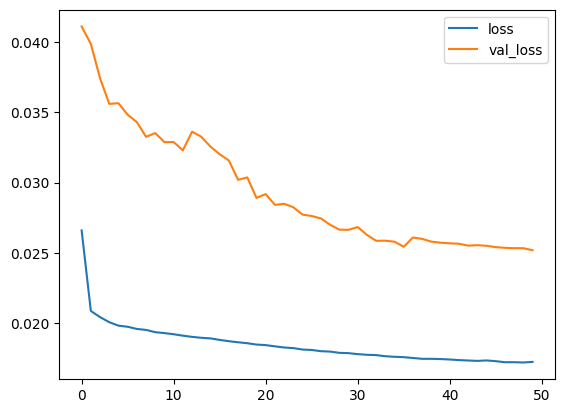

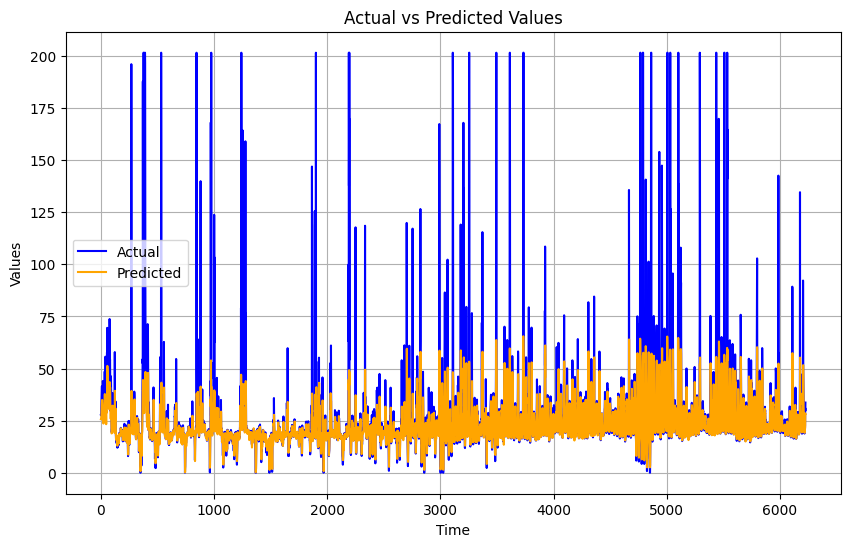

Training and plotting best model based on RMSE:
Best hyperparameters: units=50, batch_size=64, epochs=20, optimizer=adam
Best RMSE=16.757869175681925, Best MAE=5.634310302324293


/Users/dx0zart/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


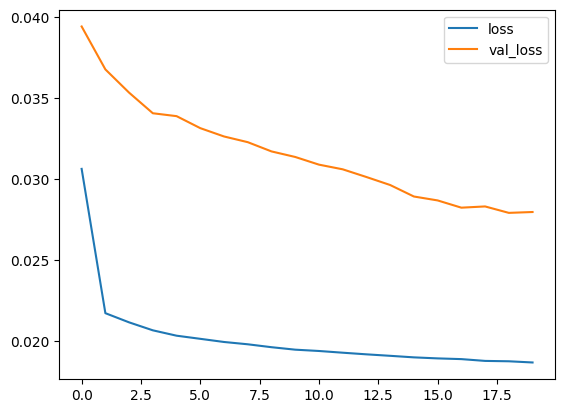

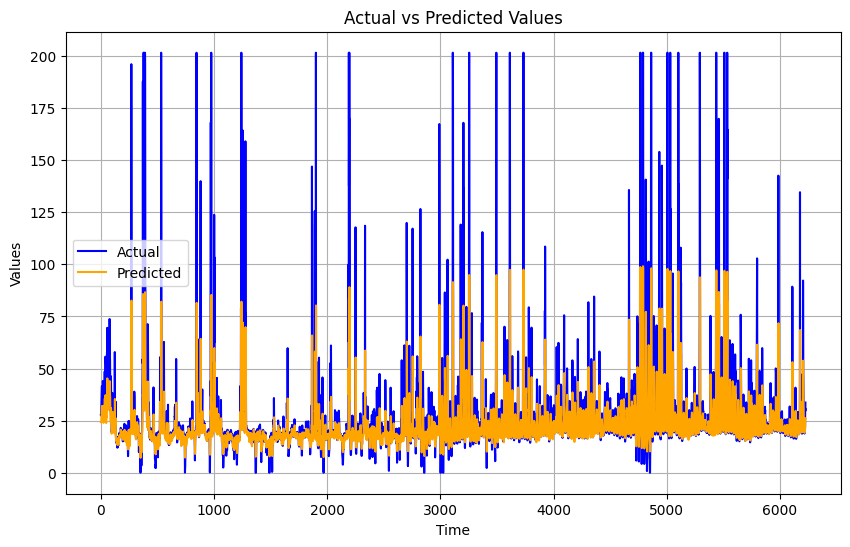

In [37]:
print("Training and plotting best model based on MAE:")
train_and_plot_best_model(results, train_X, train_y, test_X, test_y, metric='mae')

print("Training and plotting best model based on RMSE:")
train_and_plot_best_model(results, train_X, train_y, test_X, test_y, metric='rmse')

##### Conclusion
- As we can observe from the comparing the two graphs, the remse-optimized model perfromces better in predicting the abnormalities, while the mae-optimized model outperforms in terms of the overall normal values.

- Both model has pros and cons: RMSE-Optimized Modelis better at minimizing the overall error magnitude, _useful when large errors are particularly undesirable._ And MAE-Optimized Model provides _a more consistent prediction_ with smaller average errors, less sensitive to outliers.

Thus, I would suggest: 
- Use the RMSE-Optimized Model for scenarios where avoiding large errors is crucial.
- Use the MAE-Optimized Model for day-to-day operations where average accuracy is more critical.
